## Assignment 1

We first import the necessary libraries:

In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
from numba import njit, float64
from numba.experimental import jitclass
from scipy.optimize import fsolve, minimize_scalar, bisect
from interpolation import interp
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

We redefine `scipy.optimize.minimize` to a maximizer function, because we have to maximize something in the Bellman-equation. 

In [84]:
def maximize(g, a, b, args):
    """
    Maximize the function g over the interval [a, b].

    We use the fact that the maximizer of g on any interval is
    also the minimizer of -g.  The tuple args collects any extra
    arguments to g.

    Returns the maximal value and the maximizer.
    """

    objective = lambda x: -g(x, *args)
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    maximizer, maximum = result.x, -result.fun
    return maximizer, maximum

Now, we define an instance of the neoclassical growth model. 

In [85]:
class ngm():

    def __init__(self, σ=1, β=0.984, δ=0.025, α=1/3):
        'Parameters:'
        self.σ, self.β, self.δ, self.α = σ, β, δ, α
        
        'Endogenous outcomes and endogenous grid:'
        self.steadystate = self.ss()
        self.k0 = 0.75*self.ss()
        self.grid = self.create_grid(self.steadystate)
        self.v_initial = self.v_initial()

    def u(self, c):
        'Utility function'
        σ = self.σ

        return c ** (1 - σ) / (1 - σ) if σ!= 1 else np.log(c)

    def u_prime(self, c):
        'Derivative of utility'
        σ = self.σ

        return c ** (-σ)

    def f(self, k):
        'Production function'
        α = self.α

        return k ** α

    def f_prime(self, k):
        'Derivative of production function'
        α = self.α

        return α * k ** (α - 1)
    
    def f_prime_inv(self, k):
        'Inverse of derivative of production function'
        α = self.α 

        return (k / α) ** (1 / (α - 1))

    def ss(self):
        'Define the steady-state equation s.t. RHS=0'
        β, δ = self.β, self.δ
        f_prime_inv = self.f_prime_inv
        
        return f_prime_inv(1/β - (1-δ))
    
    def create_grid(self, reference):
        'Create a grid as prescribed in the assignment'
        grid = np.linspace(0.5 * reference, 1.5 * reference, 1000)
        return grid
    
    def v_initial(self):
        'Create initialization for value function'
        grid = self.grid
        v_initial = np.zeros_like(grid)
        return v_initial      
    
    def state_action_value(self, k_new, k, v_array):
        v = lambda x: interp(self.grid, v_array, x)
        
        u, f = self.u, self.f
        β, δ = self.β, self.δ
        return u(f(k) + (1-δ)*k - k_new) + β*v(k_new)   #k_new is the thing we solve for
                                                        # This is the right hand side of the bellman

Next, we implement part two of the code, first, iteration of the Bellman equation in terms of the state variable $k$, and we solve for $k_{new}$, and then evaluate at the maximum to get a new value function:

In [86]:
def T(v, ngm):
    """
    The Bellman operator.  Updates the guess of the value function.
    * v is an array representing a guess of the value function

    """
    v_new = np.empty_like(v)
    v_array = v
    
    for i, k in enumerate(ngm.grid):
        # Maximize RHS of Bellman equation at state x
        v_new[i] = maximize(ngm.state_action_value, (1-ngm.δ)*k, ngm.f(k) + (1-ngm.δ)*k, (k, v_array))[1]

    return v_new

Ηere is the full algorithm finding the value function:

In [87]:
def compute_value_function(ngm,
                           tol=1e-4,
                           max_iter=1000,
                           verbose=True,
                           print_skip=100):
    'Compute the value function through the fixed point of a contraction mapping'
    # Set up loop
    v = ngm.v_initial # Initial guess
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v, ngm)

        error = np.max(np.abs(v - v_new))
        i += 1

        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")

        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_new

In [88]:
v_conv = compute_value_function(ngm())

Error at iteration 100 is 0.16478228195050804.
Error at iteration 200 is 0.03284130120199791.
Error at iteration 300 is 0.006545309676980082.
Error at iteration 400 is 0.0013044878613257538.
Error at iteration 500 is 0.0002599859539884619.

Converged in 560 iterations.


In [89]:
def π(ngm, v):
    'Find the policy function given a model instance and a (converged) value function'
    k_prime = np.zeros_like(v)
    c_prime = np.zeros_like(v)
    
    for i in range(len(ngm.grid)):
        k = ngm.grid[i]
        # Maximize RHS of Bellman equation at state x
        k_prime[i] = maximize(ngm.state_action_value, (1-ngm.δ)*k, ngm.f(k) + (1-ngm.δ)*k, (k, v))[0] #K_t+1
        c_prime[i] = ngm.f(k) + (1-ngm.δ)*k - k_prime[i]  #C_t
    
    return c_prime, k_prime
    

In [106]:
c_opt, k_opt = π(ngm(), v_conv)

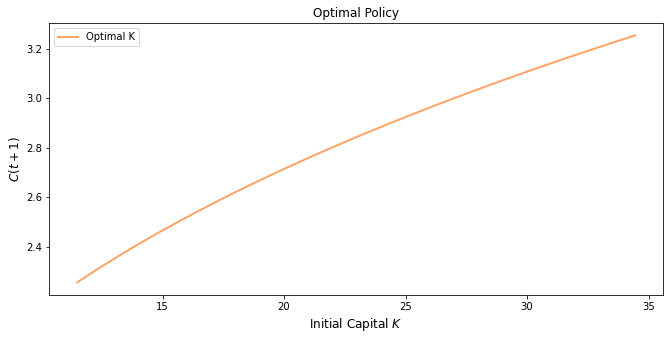

In [107]:
fig, ax = plt.subplots()

#ax.plot(ngm().grid, k_opt, color=plt.cm.jet(0),
#        lw=2, alpha=0.6, label = 'Optimal K')

ax.plot(ngm().grid, c_opt, color=plt.cm.jet(4/5),
        lw=2, alpha=0.6, label = 'Optimal K')
#ax.axvline(x=ngm().steadystate)
#ax.hlines(y=ngm().steadystate, xmin = 10, xmax = 35)


ax.legend()
ax.set_ylabel('$C(t+1)$', fontsize=12)
ax.set_xlabel('Initial Capital $K$', fontsize=12)
ax.set_title('Optimal Policy')

plt.show()

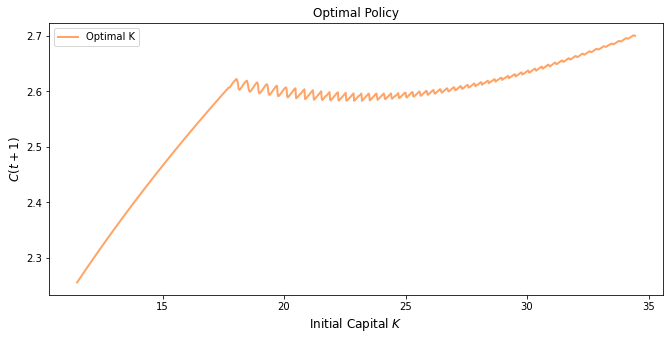

In [108]:
#v_conv_5 = compute_value_function(ngm(σ=5))
c_opt, k_opt = π(ngm(σ=5), v_conv_5)

fig, ax = plt.subplots()

ax.plot(ngm().grid, c_opt, color=plt.cm.jet(4/5),
        lw=2, alpha=0.6, label = 'Optimal K')



ax.legend()
ax.set_ylabel('$C(t+1)$', fontsize=12)
ax.set_xlabel('Initial Capital $K$', fontsize=12)
ax.set_title('Optimal Policy')

plt.show()

In [109]:
def plot_policy(ngm, v, T):
    'Plot a policy function starting from k0, on the basis of an array of the policy function'
    grid = ngm.grid
    
    k = []
    k.append(ngm.k0)
    
    for i in range(T):
        k.append(
            maximize(
                ngm.state_action_value, (1-ngm.δ)*k[i-1], ngm.f(k[i-1]) + (1-ngm.δ)*k[i-1], (k[i-1], v))[0])
        
    fig, ax = plt.subplots()
    ax.plot(range(T+1), k, color=plt.cm.jet(0),
        lw=2, alpha=0.6, label = 'Policy Path Starting from k0')
    
    ax.legend()
    ax.set_ylabel('Optimal Capital Chosen', fontsize=12)
    ax.set_xlabel('Time $t$', fontsize=12)
    ax.set_title('Optimal Policy Starting from $K_0$')
    
    plt.show()
    

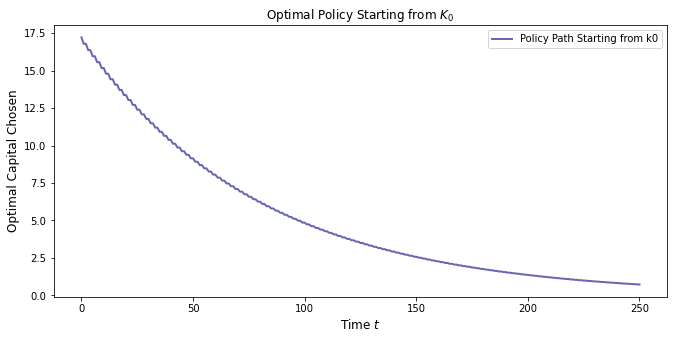

In [111]:
plot_policy(ngm(σ=5), v_conv_5, 250)

In [113]:
ngm().steadystate

22.962634609403963

In [48]:
# Still some mistakes in code, although basic architecture should work.. 